# Converting a simple NetCDF file to a TileDB array

## Import packages

In [1]:
import netCDF4
import numpy as np
import tiledb
from tiledb.cf import Group, GroupSchema
from tiledb.cf.engines.netcdf4_engine import NetCDF4ConverterEngine
import matplotlib.pyplot as plt

## Create an example NetCDF file

### Example dataset

Create two 100x100 numpy arrays:

In [2]:
x_data = np.linspace(-5.0, 5.0, 100)
y_data = np.linspace(-5.0, 5.0, 100)
xv, yv = np.meshgrid(x_data, y_data, sparse=True)
A1_data = xv + yv
A2_data = np.sin((xv / 2.0) ** 2 + yv ** 2)

If the file does not exist yet, write the example data to a netcdf file:

In [3]:
netcdf_file = "output/simple1.nc"
vfs = tiledb.VFS()
if not vfs.is_file(netcdf_file):
    with netCDF4.Dataset(netcdf_file, mode="w") as dataset:
        dataset.setncatts({"title": "Simple dataset for examples"})
        dataset.createDimension("x", 100)
        dataset.createDimension("y", 100)
        A1 = dataset.createVariable("A1", np.float64, ("x", "y"))
        A1.setncattr("full_name", "Example matrix A1")
        A1.setncattr("description", "x + y")
        A1[:, :] = A1_data
        A2 = dataset.createVariable("A2", np.float64, ("x", "y"))
        A2[:, :] = A2_data
        A2.setncattr("full_name", "Example matrix A2")
        A2.setncattr("description", "sin((x/2)^2 + y^2")
        x1 = dataset.createVariable("x_data", np.float64, ("x",))
        x1[:] = x_data
        y = dataset.createVariable("y_data", np.float64, ("y",))
        y[:] = y_data
    print(f"Created example NetCDF file `{netcdf_file}`.")
else:
    print(f"Example NetCDF file `{netcdf_file}` already exists.")


Created example NetCDF file `output/simple1.nc`.


Examine the variables in the netcdf file:

In [4]:
netcdf_data = netCDF4.Dataset(netcdf_file)
print(netcdf_data.variables)

{'A1': <class 'netCDF4._netCDF4.Variable'>
float64 A1(x, y)
    full_name: Example matrix A1
    description: x + y
unlimited dimensions: 
current shape = (100, 100)
filling on, default _FillValue of 9.969209968386869e+36 used, 'A2': <class 'netCDF4._netCDF4.Variable'>
float64 A2(x, y)
    full_name: Example matrix A2
    description: sin((x/2)^2 + y^2
unlimited dimensions: 
current shape = (100, 100)
filling on, default _FillValue of 9.969209968386869e+36 used, 'x_data': <class 'netCDF4._netCDF4.Variable'>
float64 x_data(x)
unlimited dimensions: 
current shape = (100,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'y_data': <class 'netCDF4._netCDF4.Variable'>
float64 y_data(y)
unlimited dimensions: 
current shape = (100,)
filling on, default _FillValue of 9.969209968386869e+36 used}


## Convert the NetCDF file to a TileDB array

Before converting the file create a converter that contains the parameters for the conversion. 

Optionally the following parameters can be added:

* `unlimited_dim_size`: The size of the domain for TileDB dimensions created from unlimited NetCDF dimensions.
* `dim_dtype`: The numpy dtype for TileDB dimensions.
* `tiles_by_var`: A map from the name of a NetCDF variable to the tiles of the dimensions of the variable in the generated NetCDF array.
* `tiles_by_dims`: A map from the name of NetCDF dimensions defining a variable to the tiles of those dimensions in the generated NetCDF array.
* `collect_attrs`: If True, store all attributes with the same dimensions in the same array. Otherwise, store each attribute in a scalar array.
* `collect_scalar_attrs`: If True, store all attributes with no dimensions in the same array. This is always done if collect_attributes=True.

For example, the below converter will create a separate array for each of the attributes in the NetCDf file with `collect_attrs=False`:

```
converter = NetCDF4ConverterEngine.from_file(
    netcdf_file,
    collect_attrs = False
)
```

In [5]:
converter = NetCDF4ConverterEngine.from_file(
    netcdf_file,
    dim_dtype = np.uint32,
    tiles_by_var = {("x", "y"): (20,20), ("x",): (20,), ("y",): (20,)},
)
converter

DataspaceCreator(
 Shared Dimensions:
  'x':  Dimension(name=x, size=100) -> SharedDim(name=x, domain=(0, 99), dtype='uint32'),
  'y':  Dimension(name=y, size=100) -> SharedDim(name=y, domain=(0, 99), dtype='uint32'),

 Array Creators:
  'array0':  ArrayCreator(
     domain=Domain(*[
       DimCreator(Dimension(name=x, size=100) -> SharedDim(name=x, domain=(0, 99), dtype='uint32'), tile=None),
     ]),
     attrs=[
       Variable(name=x_data, dtype=float64) -> AttrCreator(name=x_data, dtype='float64', var=False, nullable=False),
     ],
     cell_order='row-major',
     tile_order='row-major',
     capacity=0,
     sparse=False,
  )
  'array1':  ArrayCreator(
     domain=Domain(*[
       DimCreator(Dimension(name=x, size=100) -> SharedDim(name=x, domain=(0, 99), dtype='uint32'), tile=None),
       DimCreator(Dimension(name=y, size=100) -> SharedDim(name=y, domain=(0, 99), dtype='uint32'), tile=None),
     ]),
     attrs=[
       Variable(name=A1, dtype=float64) -> AttrCreator(name=A1,

Rename the array names to be more descriptive:

In [6]:
converter.rename_array('array0', 'x')
converter.rename_array('array1', 'matrices')
converter.rename_array('array2', 'y')

Run the conversions to create two dense TileDB arrays:

In [7]:
group_uri = "output/tiledb_simple1"
converter.convert_to_group(group_uri)

## Examine the TileDB group schema

In [8]:
group_schema = GroupSchema.load(group_uri)
group_schema

GroupSchema:
Group metadata schema: ArraySchema(
  domain=Domain(*[
    Dim(name='dim', domain=(0, 0), tile='1', dtype='int32'),
  ]),
  attrs=[
    Attr(name='attr', dtype='int32', var=False, nullable=False),
  ],
  cell_order='row-major',
  tile_order='row-major',
  capacity=10000,
  sparse=False,
  coords_filters=FilterList([ZstdFilter(level=-1)]),
)
'matrices': ArraySchema(
  domain=Domain(*[
    Dim(name='x', domain=(0, 99), tile='100', dtype='uint32'),
    Dim(name='y', domain=(0, 99), tile='100', dtype='uint32'),
  ]),
  attrs=[
    Attr(name='A1', dtype='float64', var=False, nullable=False),
    Attr(name='A2', dtype='float64', var=False, nullable=False),
  ],
  cell_order='row-major',
  tile_order='row-major',
  capacity=10000,
  sparse=False,
  coords_filters=FilterList([ZstdFilter(level=-1)]),
)
'x': ArraySchema(
  domain=Domain(*[
    Dim(name='x', domain=(0, 99), tile='100', dtype='uint32'),
  ]),
  attrs=[
    Attr(name='x_data', dtype='float64', var=False, nullable=False

## Examine the data in the arrays

Open the attributes from the generated TileDB group:

In [9]:
with Group(group_uri, attr="x_data") as group:
    x = group.array[:]
with Group(group_uri, attr="y_data") as group:
    y = group.array[:]
with Group(group_uri, array="matrices") as group:
    data = group.array[...]
    A1 = data["A1"]
    A2 = data["A2"]
    a1_description = group.get_attr_metadata("A1")["description"]
    a2_description = group.get_attr_metadata("A2")["description"]

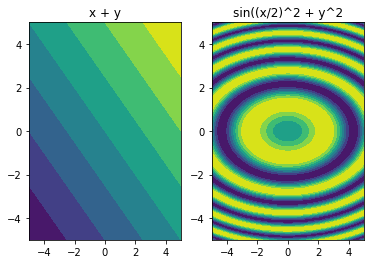

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].contourf(x, y, A1);
axes[0].set_title(a1_description);
axes[1].contourf(x, y, A2);
axes[1].set_title(a2_description);